In [1]:
from bandit import Bandits, Bandits_one, Bandits_two, Bandits_three, Bandits_four
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np

In [2]:
np.random.seed(123)

In [3]:
def get_optimal_mean_reward(mab):
    optimal_action = mab.get_optimal_action()
    return mab.means[optimal_action] if mab.state is None else mab.means[mab.state][optimal_action]

In [4]:
def epsilon_greedy(mab, T, epsilon, optimistic_init_val):
    est_vals = np.full(mab.k, optimistic_init_val)
    action_counts = np.zeros(mab.k)
    total_reward = 0
    regrets = np.zeros(T)

    optimal_mean_reward = get_optimal_mean_reward(mab)

    for t in range(T):
        if np.random.rand() < epsilon:
            action = np.random.choice(mab.k)  # exploration
        else:
            action = np.argmax(est_vals)  # exploitation

        _, reward, _, _, _ = mab.step(action)
        regret = optimal_mean_reward - reward

        action_counts[action] += 1
        est_vals[action] += (reward - est_vals[action]) / action_counts[action]  # online upd formula for the exp value
        total_reward += reward
        regrets[t] = regret if t == 0 else regrets[t - 1] + regret  # cumulative regret

    return est_vals, total_reward, regrets, action_counts


def decaying_epsilon_greedy(mab, T, epsilon, alpha, optimistic_init_val):
    est_vals = np.full(mab.k, optimistic_init_val)
    action_counts = np.zeros(mab.k)
    total_reward = 0
    eps = epsilon
    regrets = np.zeros(T)

    optimal_mean_reward = get_optimal_mean_reward(mab)

    for t in range(T):
        if np.random.rand() < eps:
            action = np.random.choice(mab.k)
        else:
            action = np.argmax(est_vals)

        _, reward, _, _, _ = mab.step(action)
        regret = optimal_mean_reward - reward

        action_counts[action] += 1
        est_vals[action] += (reward - est_vals[action]) / action_counts[action]
        total_reward += reward
        eps *= alpha
        regrets[t] = regret if t == 0 else regrets[t - 1] + regret

    return est_vals, total_reward, regrets, action_counts


def ucb(mab, T, c, optimistic_init_val):
    est_vals = np.full(mab.k, optimistic_init_val)
    action_counts = np.zeros(mab.k) + 1e-10  # avoid div by zero
    total_reward = 0
    regrets = np.zeros(T)

    optimal_mean_reward = get_optimal_mean_reward(mab)

    for t in range(1, T + 1):
        confidence_bound = c * np.sqrt(2 * np.log(t) / action_counts)
        action = np.argmax(est_vals + confidence_bound)

        _, reward, _, _, _ = mab.step(action)
        regret = optimal_mean_reward - reward

        action_counts[action] += 1
        est_vals[action] += (reward - est_vals[action]) / action_counts[action]
        total_reward += reward
        regrets[t - 1] = regret if t == 1 else regrets[t - 2] + regret

    return est_vals, total_reward, regrets, action_counts

In [5]:
def evaluate_bandit_algorithms(mab, num_runs, episodes, eps, alpha, c, optimistic_init_val=0):
    algorithms = {
        'ε-Greedy': {
            'func': epsilon_greedy,
            'params': {'epsilon': eps},
            'total_reward': 0,
            'avg_est_vals': np.zeros(mab.k),
            'avg_regrets': np.zeros(episodes),
            'avg_action_counts': np.zeros(mab.k)
        },
        'Decaying ε-Greedy': {
            'func': decaying_epsilon_greedy,
            'params': {'epsilon': eps, 'alpha': alpha},
            'total_reward': 0,
            'avg_est_vals': np.zeros(mab.k),
            'avg_regrets': np.zeros(episodes),
            'avg_action_counts': np.zeros(mab.k)
        },
        'UCB': {
            'func': ucb,
            'params': {'c': c},
            'total_reward': 0,
            'avg_est_vals': np.zeros(mab.k),
            'avg_regrets': np.zeros(episodes),
            'avg_action_counts': np.zeros(mab.k)
        }
    }

    for _ in range(num_runs):
        for name, algorithm in algorithms.items():
            mab.reset()
            est_vals, total_reward, regrets, action_counts = algorithm['func'](mab, episodes, **algorithm['params'],
                                                                               optimistic_init_val=optimistic_init_val)

            algorithm['avg_est_vals'] += est_vals
            algorithm['total_reward'] += total_reward
            algorithm['avg_regrets'] += regrets
            algorithm['avg_action_counts'] += action_counts

    results = []
    avg_regrets_list = []
    for name, algorithm in algorithms.items():
        avg_est_vals = algorithm['avg_est_vals'] / num_runs
        total_reward = algorithm['total_reward'] / num_runs
        avg_regrets = algorithm['avg_regrets'] / num_runs
        avg_action_counts = algorithm['avg_action_counts'] / num_runs
        max_action_count = np.argmax(avg_action_counts) + 1

        results.append([name, *avg_est_vals, total_reward, avg_action_counts, max_action_count])
        avg_regrets_list.append(avg_regrets)

    return results, avg_regrets_list

In [6]:
def plot_avg_cumulative_regret(avg_regrets, mab_name):
    plt.plot(avg_regrets[0], color="yellowgreen", label="ε-Greedy")
    plt.plot(avg_regrets[1], color="cornflowerblue", label="Decaying ε-Greedy")
    plt.plot(avg_regrets[2], color="palevioletred", label="UCB")
    plt.xlabel("Episodes")
    plt.ylabel("Avg Cumulative Regret")
    plt.title(f"[{mab_name}]\nAvg Cumulative Regret of ε-Greedy,\nDecaying ε-Greedy and UCB")
    plt.legend()
    plt.show()

In [7]:
episodes = 1000
num_runs = 20

# Bandit 1

In [8]:
headers_avg_mab1 = ["Algorithm", "A", "B", "C", "Total Reward", "Avg Action Counts", "Most Chosen Action"]
data_avg_mab1, avg_regrets_mab1 = evaluate_bandit_algorithms(Bandits_one(), num_runs, episodes,
                                                             eps=0.1, alpha=0.99, c=1, optimistic_init_val=3.5)

In [9]:
print(tabulate(data_avg_mab1, headers=headers_avg_mab1, tablefmt="simple"))

Algorithm                A        B        C    Total Reward  Avg Action Counts         Most Chosen Action
-----------------  -------  -------  -------  --------------  ----------------------  --------------------
ε-Greedy           1.00346  1.92958  3.00239         2892.99  [ 32.7   41.15 926.15]                     3
Decaying ε-Greedy  1.10849  1.9438   2.99429         2964.71  [  4.6  20.9 974.5]                        3
UCB                0.75513  1.69704  3.00583         2986.82  [  3.5  11.4 985.1]                        3


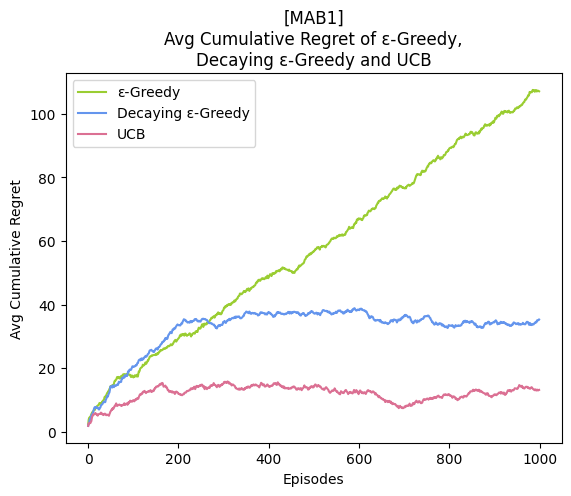

In [10]:
plot_avg_cumulative_regret(avg_regrets_mab1, "MAB1")

# Bandit 2

In [11]:
headers_avg_mab2 = ["Algorithm", "A", "B", " C", "D", "Total Reward", "Avg Action Counts", "Most Chosen Action"]
data_avg_mab2, plot_avg_regrets_mab2 = evaluate_bandit_algorithms(Bandits_two(), num_runs, episodes,
                                                                  eps=0.2, alpha=0.99, c=1, optimistic_init_val=3.5)

In [12]:
print(tabulate(data_avg_mab2, headers=headers_avg_mab2, tablefmt="simple"))

Algorithm                 A        B        C        D    Total Reward  Avg Action Counts                Most Chosen Action
-----------------  --------  -------  -------  -------  --------------  -----------------------------  --------------------
ε-Greedy           0.934941  2.0468   2.98898  2.47021         2807.34  [ 49.6  50.6 836.9  62.9]                         3
Decaying ε-Greedy  0.915516  1.76348  2.98073  2.35223         2961.1   [  6.3    5.9  927.25  60.55]                     3
UCB                0.791751  1.75354  3.01198  2.36875         2976.53  [  3.7   10.15 953.1   33.05]                     3


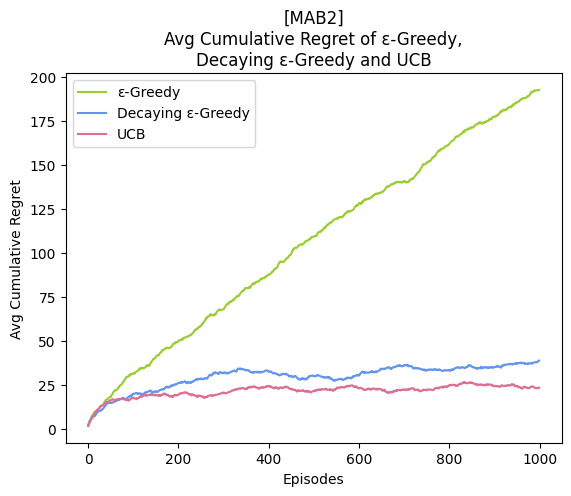

In [13]:
plot_avg_cumulative_regret(plot_avg_regrets_mab2, "MAB2")

# Bandit 3

In [14]:
headers_avg_mab3 = ["Algorithm", "X", "Y", "Z", "Total Reward", "Avg Action Counts", "Most Chosen Action"]
data_avg_mab3, avg_regrets_mab3 = evaluate_bandit_algorithms(Bandits_three(), num_runs, episodes,
                                                             eps=0.2, alpha=0.99, c=1, optimistic_init_val=2.5)

In [15]:
print(tabulate(data_avg_mab3, headers=headers_avg_mab3, tablefmt="simple"))

Algorithm                X        Y        Z    Total Reward  Avg Action Counts         Most Chosen Action
-----------------  -------  -------  -------  --------------  ----------------------  --------------------
ε-Greedy           2.00994  1.50381  2.10725         2058.09  [399.7   82.45 517.85]                     3
Decaying ε-Greedy  1.9598   1.35534  1.69461         2067.2   [697.3   13.85 288.85]                     1
UCB                1.99706  1.48175  1.2953          2097.66  [483.4   31.15 485.45]                     3


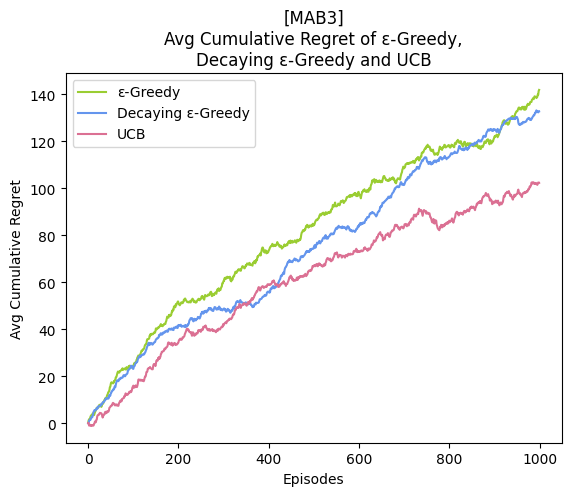

In [16]:
plot_avg_cumulative_regret(avg_regrets_mab3, "MAB3")

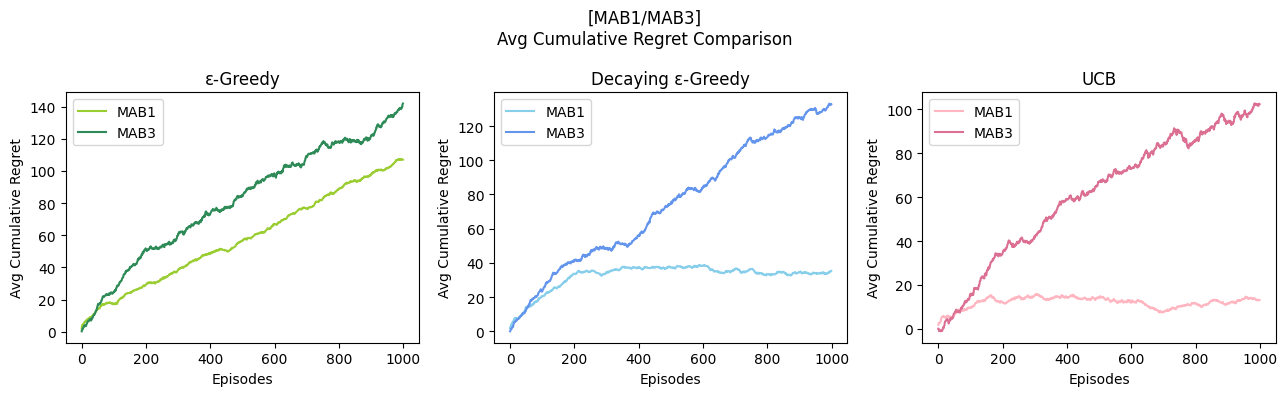

In [17]:
colors = [("yellowgreen", "seagreen"), ("skyblue", "cornflowerblue"), ("lightpink", "palevioletred")]
titles = ["ε-Greedy", "Decaying ε-Greedy", "UCB"]
plot_avg_regrets_mabs = [(avg_regrets_mab1[0], avg_regrets_mab3[0]),
                         (avg_regrets_mab1[1], avg_regrets_mab3[1]),
                         (avg_regrets_mab1[2], avg_regrets_mab3[2])]

fig, axs = plt.subplots(1, 3, figsize=(13, 4))

for i, ax in enumerate(axs):
    ax.plot(plot_avg_regrets_mabs[i][0], color=colors[i][0], label="MAB1")
    ax.plot(plot_avg_regrets_mabs[i][1], color=colors[i][1], label="MAB3")
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Avg Cumulative Regret")
    ax.set_title(titles[i])
    ax.legend()

plt.suptitle("[MAB1/MAB3]\nAvg Cumulative Regret Comparison")
plt.tight_layout()
plt.show()

# Bandit 4

In [18]:
data_avg_mab4_g0, avg_regrets_mab4_g0 = evaluate_bandit_algorithms(Bandits_four(gene=0), num_runs, episodes,
                                                                   eps=0.3, alpha=0.999, c=2, optimistic_init_val=2.5)
data_avg_mab4_g1, avg_regrets_mab4_g1 = evaluate_bandit_algorithms(Bandits_four(gene=1), num_runs, episodes,
                                                                   eps=0.2, alpha=0.99, c=1.5, optimistic_init_val=3.5)

In [19]:
print(tabulate(data_avg_mab4_g0, headers=headers_avg_mab3, tablefmt="simple"))

Algorithm                 X        Y        Z    Total Reward  Avg Action Counts         Most Chosen Action
-----------------  --------  -------  -------  --------------  ----------------------  --------------------
ε-Greedy           0.996893  1.98778  2.18284         2010.51  [101.4  366.55 532.05]                     3
Decaying ε-Greedy  1.05996   1.97129  2.12932         2076.89  [ 64.45 394.75 540.8 ]                     3
UCB                0.950211  1.99409  1.509           2093.17  [ 28.8  443.05 528.15]                     3


In [20]:
print(tabulate(data_avg_mab4_g1, headers=headers_avg_mab3, tablefmt="simple"))

Algorithm                X         Y        Z    Total Reward  Avg Action Counts         Most Chosen Action
-----------------  -------  --------  -------  --------------  ----------------------  --------------------
ε-Greedy           2.99814  1.03424   2.12773         2800.65  [856.8  68.3  74.9]                        1
Decaying ε-Greedy  2.99794  1.03757   2.02098         2974.44  [981.2    7.75  11.05]                     1
UCB                3.00837  0.892365  1.40297         2969.52  [957.   7.  36.]                           1


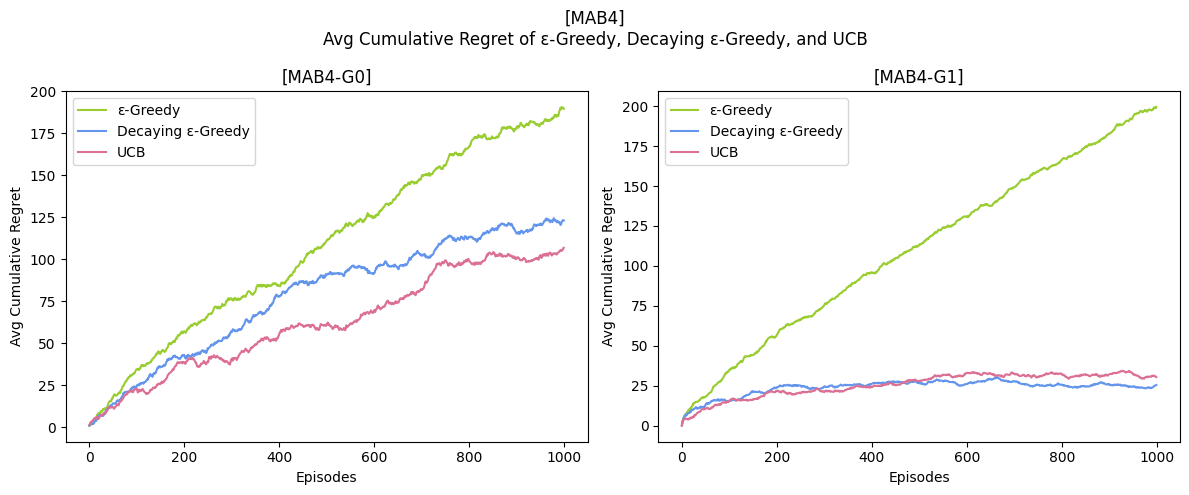

In [21]:
datasets = [avg_regrets_mab4_g0, avg_regrets_mab4_g1]
dataset_names = ["MAB4-G0", "MAB4-G1"]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, (dataset, name) in enumerate(zip(datasets, dataset_names)):
    plt.sca(axs[i])
    plt.plot(dataset[0], color="yellowgreen", label="ε-Greedy")
    plt.plot(dataset[1], color="cornflowerblue", label="Decaying ε-Greedy")
    plt.plot(dataset[2], color="palevioletred", label="UCB")
    plt.xlabel("Episodes")
    plt.ylabel("Avg Cumulative Regret")
    plt.title(f"[{name}]")
    plt.legend()

plt.suptitle("[MAB4]\nAvg Cumulative Regret of ε-Greedy, Decaying ε-Greedy, and UCB")
plt.tight_layout()
plt.show()